In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
noisy_path = "../../../data/noisylabels/CIFAR-10_human.pt"
noisy_labels = {k: torch.tensor(v) for k, v in torch.load(noisy_path).items()}
keys_to_test = ["aggre_label", "random_label1", "worse_label"]

In [ ]:
results = dict()
seeds = [1337, 42, 1]
for seed in seeds:
    results.setdefault(seed, dict())
    for key in keys_to_test:
        try:
            memo_results = torch.load(f"memo_results_{key}_{seed}.pt")
        except FileNotFoundError:
            if seed in results:
                results.pop(seed)
            continue
        results[seed][key] = memo_results

In [6]:
memo_results_mean = {}
memo_results_unc = {}
for key in keys_to_test:
    human_clean = []
    human_wrong = []
    synthetic_clean = []
    synthetic_wrong = []
    for seed in results.keys():
        human_clean.append(results[seed][key]["human"]["clean"])
        human_wrong.append(results[seed][key]["human"]["wrong"])
        synthetic_clean.append(results[seed][key]["synthetic"]["clean"])
        synthetic_wrong.append(results[seed][key]["synthetic"]["wrong"])
    human_clean = torch.tensor(human_clean)
    human_wrong = torch.tensor(human_wrong)
    synthetic_clean = torch.tensor(synthetic_clean)
    synthetic_wrong = torch.tensor(synthetic_wrong)
    memo_results_mean[key] = {
        "human": {"clean": human_clean.mean(0), "wrong": human_wrong.mean(0)},
        "synthetic": {
            "clean": synthetic_clean.mean(0),
            "wrong": synthetic_wrong.mean(0),
        },
    }
    memo_results_unc[key] = {
        "human": {
            "clean": human_clean.std(0) / np.sqrt(human_clean.shape[0]),
            "wrong": human_wrong.std(0) / np.sqrt(human_wrong.shape[0]),
        },
        "synthetic": {
            "clean": synthetic_clean.std(0) / np.sqrt(synthetic_clean.shape[0]),
            "wrong": synthetic_wrong.std(0) / np.sqrt(synthetic_wrong.shape[0]),
        },
    }

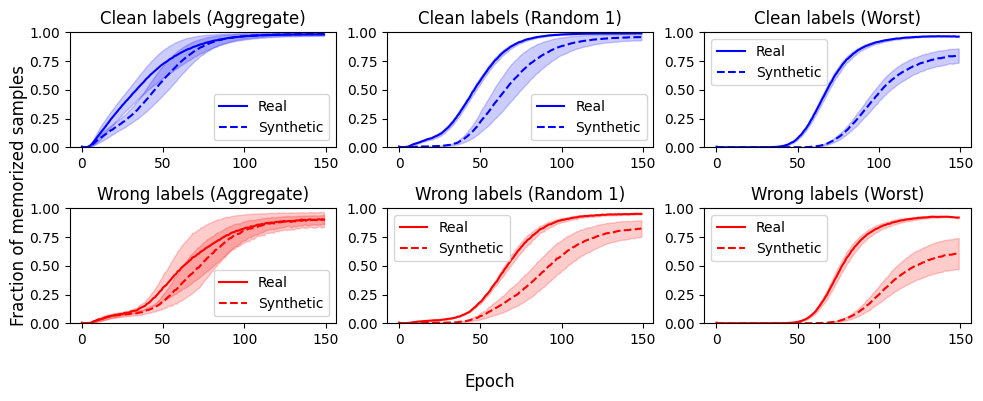

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

noise_names = {
    "aggre_label": "Aggregate",
    "random_label1": "Random 1",
    "worse_label": "Worst",
}
for i, key in enumerate(keys_to_test):
    ax[0, i].set_title(f"Clean labels ({noise_names[key]})")
    ax[0, i].plot(memo_results_mean[key]["human"]["clean"], "b", label="Real")
    ax[0, i].plot(
        memo_results_mean[key]["synthetic"]["clean"], "b--", label="Synthetic"
    )
    ax[0, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["human"]["clean"]
        - memo_results_unc[key]["human"]["clean"],
        memo_results_mean[key]["human"]["clean"]
        + memo_results_unc[key]["human"]["clean"],
        color="b",
        alpha=0.2,
    )
    ax[0, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["synthetic"]["clean"]
        - memo_results_unc[key]["synthetic"]["clean"],
        memo_results_mean[key]["synthetic"]["clean"]
        + memo_results_unc[key]["synthetic"]["clean"],
        color="b",
        alpha=0.2,
    )

    ax[1, i].set_title(f"Wrong labels ({noise_names[key]})")
    ax[1, i].plot(memo_results_mean[key]["human"]["wrong"], "r", label="Real")
    ax[1, i].plot(
        memo_results_mean[key]["synthetic"]["wrong"], "r--", label="Synthetic"
    )

    ax[1, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["human"]["wrong"]
        - memo_results_unc[key]["human"]["wrong"],
        memo_results_mean[key]["human"]["wrong"]
        + memo_results_unc[key]["human"]["wrong"],
        color="r",
        alpha=0.2,
    )

    ax[1, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["synthetic"]["wrong"]
        - memo_results_unc[key]["synthetic"]["wrong"],
        memo_results_mean[key]["synthetic"]["wrong"]
        + memo_results_unc[key]["synthetic"]["wrong"],
        color="r",
        alpha=0.2,
    )

    ax[0, i].legend()
    ax[1, i].legend()
    ax[0, i].set_ylim(0, 1)
    ax[1, i].set_ylim(0, 1)

fig.supxlabel("Epoch")
fig.supylabel("Fraction of memorized samples")
plt.tight_layout()

plt.savefig("memorization.pdf", dpi=600)
plt.show()